# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, padding="valid")
        self.pool1 = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding="same")
        self.pool2 = nn.MaxPool2d(3, 2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding="same")
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding="same")
        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding="same")
        self.pool5 = nn.MaxPool2d(3, 2)
        
        self.fc6 = nn.Linear(6400, 4096)
        self.dropout6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(4096, 4096)
        self.dropout7 = nn.Dropout(0.5)
        
        self.fc8 = nn.Linear(4096, 20)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.forward_features(x)
        x = F.relu(x)
        x = self.dropout7(x)
        x = self.fc8(x)
        x = self.sigmoid(x)
        return x
    
    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.dropout6(x)
        x = self.fc7(x)
        return x

## 2.2 Save the Model (5 pts)
Fill out `save_model()` in `trainer.py` to save the checkpoints of the model periodically. **You will need these models later.**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. The final MAP should be at least around 0.4. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [2]:
args = ARGS(epochs=50, batch_size=32, lr=0.0001, gamma=0.95, log_every=250, val_every=250, inp_size=224, save_freq=5, use_cuda=True)
model = CaffeNet()
model.to()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.step_size, args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, model_name='caffenet_scratch')
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.691711
0.0784589675504003
Train Epoch: 1 [250 (59%)]	Loss: 0.224166
0.10554606550987836
Train Epoch: 3 [500 (18%)]	Loss: 0.199720
0.14652089394284556
Train Epoch: 4 [750 (78%)]	Loss: 0.213377
0.19086541337939167
Train Epoch: 6 [1000 (37%)]	Loss: 0.238671
0.23338250653705117
Train Epoch: 7 [1250 (96%)]	Loss: 0.214446
0.26570668064757674
Train Epoch: 9 [1500 (55%)]	Loss: 0.153335
0.2923314497099425
Train Epoch: 11 [1750 (15%)]	Loss: 0.175858
0.308810695803064
Train Epoch: 12 [2000 (74%)]	Loss: 0.169708
0.3196483782617757
Train Epoch: 14 [2250 (33%)]	Loss: 0.173147
0.3370750674621268
Train Epoch: 15 [2500 (92%)]	Loss: 0.161965
0.35716942658721074
Train Epoch: 17 [2750 (52%)]	Loss: 0.165715
0.3639815168932926
Train Epoch: 19 [3000 (11%)]	Loss: 0.173318
0.38216185900794974
Train Epoch: 20 [3250 (70%)]	Loss: 0.138881
0.3888815212315434
Train Epoch: 22 [3500 (29%)]	Loss: 0.137587
0.3928481051776763
Train Epoch: 23 [3750 (89%)]	Loss: 0.148573
0.39949266595229715

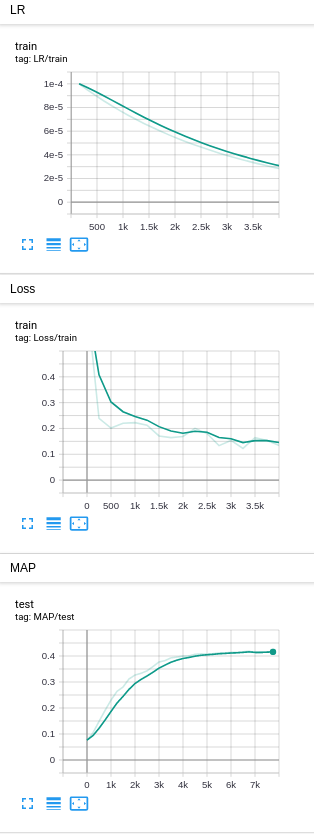

## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the weights of conv1 filters at different stages of the training (at least from 5 different epochs).

- Write a function to load your model checkpoints.
- Get the weights for conv1 from the loaded model.
- Visualize the weights using the following vis() function.

Sometimes the filters all look very random and may not change too much across epochs. Don't worry! You will get full credits as long as the code is correct.

In [3]:
import numpy as np
from PIL import Image

# This function plots all the filters in one image. 
def vis(conv1, name):
    assert type(conv1) == np.ndarray
    assert conv1.shape == (11, 11, 3, 96)
    im = np.zeros((120, 120, 3))
    step_size = 12
    column = 0
    row = 0
    for k in range(conv1.shape[3]):
        this_filter = conv1[:, :, :, k]
        im[column*step_size:column*step_size+11, row*step_size:row*step_size+11, :] = this_filter
        column = column + 1
        if column == 10:
            column = 0
            row = row + 1
    image = Image.fromarray(np.uint8((im-np.mean(im))/np.std(im)))
    #image.show()
    image.save("figures/{}.png".format(name))
    return image

In [5]:
# Write your code here to get the conv1 filters for each epoch
path_format = "models/checkpoint-caffenet_scratch-epoch{}.pth"
conv1s= []
for i in range(1, 11):
    model_path = path_format.format(i * 5)
    state_dict = torch.load(model_path)
    conv1s.append(state_dict['conv1.weight'].cpu().permute(2, 3, 1, 0).numpy())

# For each epoch, use vis() to visualize the filters.
# Before passing the weights into vis(), make sure it is an numpy array with shape (11, 11, 3, 96).
# You may need torch.permute to reorganize the dimensions.
for i, conv1 in enumerate(conv1s):
    vis(conv1, i)

epoch 0 conv1 filters:

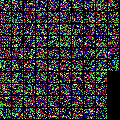

epoch 10 conv1 filters:

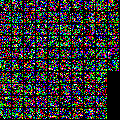

epoch 20 conv1 filters:

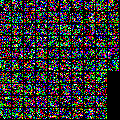

epoch 30 conv1 filters:

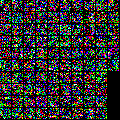

epoch 40 conv1 filters:

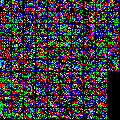